<h2> Figure with results from base-case trials</h2>

In [1]:
# Some imports to stop some annoying yellow underlines
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
import importlib

# Very important line to run the setup notebook!!!
%run do_plot_setup.ipynb
import cl2_utilities as cl2_utils

# Extract some shared values that are used to facilitate plotting. Call 'display' on any of them to see their contents.
plot_default_properties = get_and_apply_plot_defaults() #Ignore yellow underline
line_default_properties = get_default_line_properties() #Ignore yellow underline
cl2_experiment_constants = get_cl2_experiment_constants() #Ignore yellow underline
(all_conversion_data,all_bypass_data) = get_experimental_data() #Ignore underline. These two dataframes have all the experimental results.

<h1> Old Base Case <h1>

/Users/maxkessler/Documents/GitHub/Fall-2024-Cl2/_shared_packages/process_cl2_logfile.py:38: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  dfs = {label: pd.read_csv(path,parse_dates={'Timestamp':[0,1]}) for label,path in zip(labels,paths)}
/Users/maxkessler/Documents/GitHub/Fall-2024-Cl2/_shared_packages/process_cl2_logfile.py:38: DtypeWarning: Columns (46,48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = {label: pd.read_csv(path,parse_dates={'Timestamp':[0,1]}) for label,path in zip(labels,paths)}
/Users/maxkessler/Documents/GitHub/Fall-2024-Cl2/_shared_packages/process_cl2_logfile.py:494: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  prn = pd.read_csv(new_prn_path,sep='\t',parse_dates={'Timestamp':[1,2]},date_pa

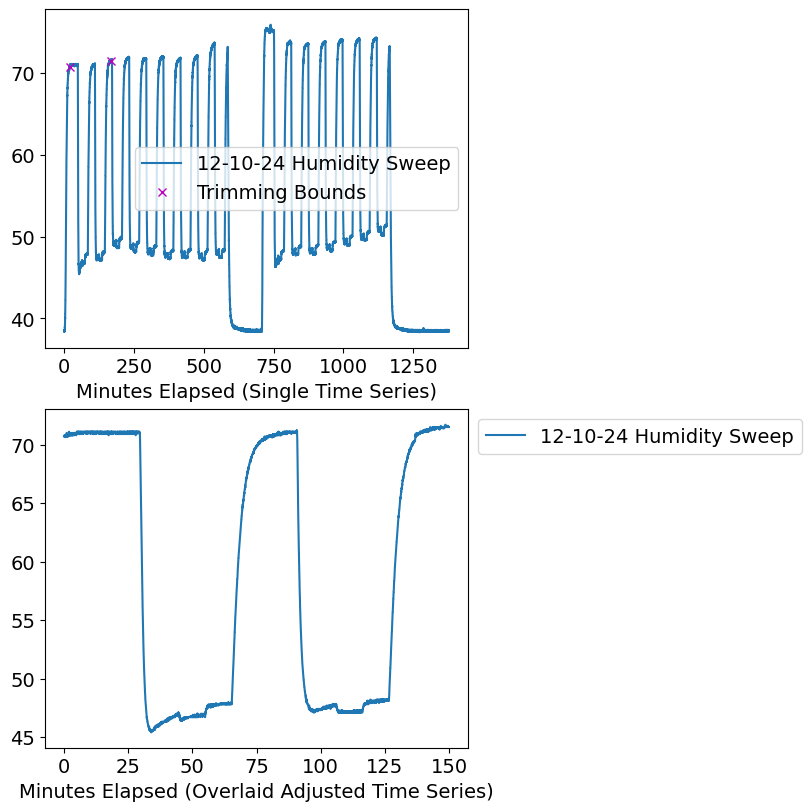

In [ ]:
import process_cl2_logfile as process_cl2#This underline is unavoidable

path = (plot_default_properties['base_directory'] + '/10-23 Cl2 Campaign Follow-Ups/data/12-10-24_humidity.csv')
exp_name = '12-10-24 Humidity Sweep'
ftir_path = plot_default_properties['base_directory'] + '/10-23 Cl2 Campaign Follow-Ups/data/12-10_ftir.prn'

info = (path,exp_name,ftir_path)

# Load the file... (path,exp_name,ftir_path)
hush=True
raw_data = process_cl2.extract_data([info[:2]], hush)

# Rebind the ftir
ftir_fields_to_rebind = (('CH4 (PF) 191c average','FTIR: CH4 (ppm)'),('CO2 ppm 191c average','FTIR: CO2 (ppm)'),
                         ('CO ppm 191C (1of2) average','FTIR: CO (ppm)'),('Formaldehyde 191c average','FTIR: CH2O (ppm)'),)

process_cl2.rebind_ftir_prn(raw_data[exp_name],ftir_path,ftir_fields_to_rebind,hush)

for df in raw_data.values():
    try:
        df['FTIR: CH2O (ppm)']+=0.5 #One can see on inspection that the 'baseline' CH2O value is -0.5, not 0, for some reason. We correct that.
    except: #FTIR widget not used, or said 'no reading' the whole time.
        pass

importlib.reload(process_cl2)
trim_params = [(20, 170)]
(data, ax1, ax2) = process_cl2.trim_dataframes(raw_data, trim_params, plot=True, which_field='Cl2 LabJack: Cl2 Node A (mV)', which_df=0)
rf = process_cl2.RemovalFinder(data, "10-23_cl2_misc_follow_ups")

importlib.reload(process_cl2)
#@np.vectorize
def subtract_cl2_zero(mv):# This zero stays fixed within a given campaign but may change from campaign to campaign due to tweaking the Cl2 sensor setup
    return (mv-39.0)

current_experiment = '12-10-24 Humidity Sweep'
rf.dump_experiment(current_experiment)
data[current_experiment]['Cl2 LabJack: Cl2 reading minus zero (mV)'] = subtract_cl2_zero(data[current_experiment]['Cl2 LabJack: Cl2 Node A (mV)'])

# Process the bypass periods
rf.set_tags('UV_distance_conv=50')
rf.isolate_bypass_periods(current_experiment)
# Process the CH4
rf.set_setup_values(which_field='FTIR: CH4 (ppm)')
rf.autofind_removal(current_experiment,start_time=0,end_time=1150,correct_drift=False)
#rf.plot_baseline_and_samples(current_experiment,which_field='Selected: CH4 (ppm)',color='C0',ax=ax_a,marker='^',do_shading=True)
# Get the Cl2 data
rf.set_setup_values(which_field='Cl2 LabJack: Cl2 reading minus zero (mV)')
rf.autofind_removal(current_experiment,start_time=0,end_time=1150,correct_drift=False)



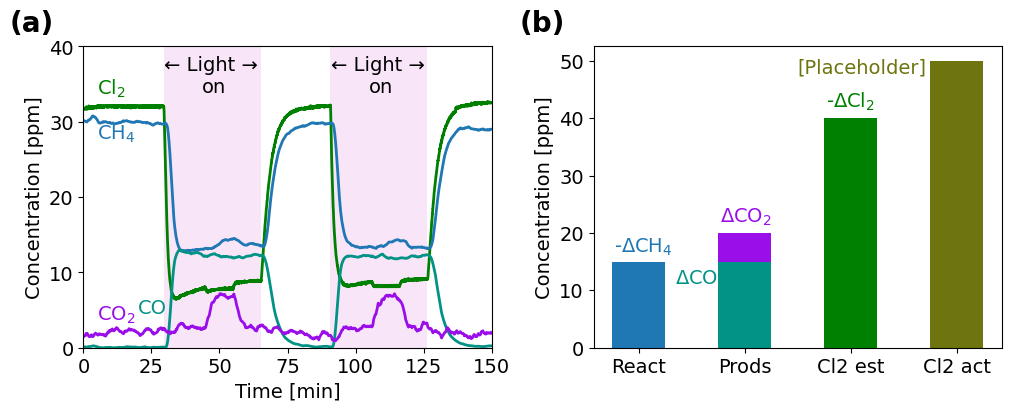

In [8]:
(fig,((ax_a,ax_b)))=plt.subplots(1,2,figsize=(plot_default_properties['figure_width'],4))

# a
ax_a.text(-0.18,1.05, "(a)", transform=ax_a.transAxes, size=plot_default_properties['subplot_letter_size'], weight='bold')

importlib.reload(process_cl2)
importlib.reload(cl2_utils)

# Add the UV light overlays
(on_times,off_times) = process_cl2.find_UV_changes(data[current_experiment]['UV Light: Actual Status'],data[current_experiment]['Minutes'])
for i in range(len(on_times)):
    ax_a.axvspan(on_times.iloc[i],off_times.iloc[i], color='m', alpha=0.1, lw=0)
ax_a.text(.32,0.97, '← Light → \non',ha='center',va='top',transform=ax_a.transAxes)
ax_a.text(0.73,0.97, '← Light → \non',ha='center',va='top',transform=ax_a.transAxes)
#ax_a.plot(data[current_experiment]['Minutes'],10*data[current_experiment]['UV Light: Actual Status'],color='xkcd:purple',label='UV Light: Status (AU)')

#rf.plot_baseline_and_samples(current_experiment,which_field='Cl2 LabJack: Cl2 reading minus zero (mV)',color='g',marker='o',ax=ax_a,do_shading=False)
cl2_utils.do_timeseries(ax_a,line_default_properties,'Cl2',data[current_experiment]['Minutes'],data[current_experiment]['Cl2 LabJack: Cl2 reading minus zero (mV)'])
cl2_utils.do_timeseries(ax_a,line_default_properties,'CH4',data[current_experiment]['Minutes'],data[current_experiment]['FTIR: CH4 (ppm)'])
cl2_utils.do_timeseries(ax_a,line_default_properties,'CO',data[current_experiment]['Minutes'],data[current_experiment]['FTIR: CO (ppm)'])
cl2_utils.do_timeseries(ax_a,line_default_properties,'CO2',data[current_experiment]['Minutes'],data[current_experiment]['FTIR: CO2 (ppm)'])

# Labeling
labels = (('Cl2',5,33,0),
          ('CH4',5,27,0),
          ('CO',20,4,0),
          ('CO2',5,3,0))
cl2_utils.label_tslines(ax_a,line_default_properties,labels)

#print(rf.translate_tags("UV_distance_conv=50; dummy='whatever'")['UV_distance_conv'])
ax_a.set_xlim(0,150)
ax_a.set_ylim(0,40)
ax_a.set_ylabel('Concentration [ppm]')
ax_a.set_xlabel('Time [min]')

#ax_a.plot([0],[0],'r*')

# b
ax_b.text(-0.18,1.05, "(b)", transform=ax_b.transAxes, size=plot_default_properties['subplot_letter_size'], weight='bold')
# Data for the bar chart
bar_labels = ['React', 'Prods', 'Cl2 est', 'Cl2 act']
bar_values = [[15], [15, 5], [40], [50]]

# Labeling
labels = (('CH4',.05,.3,0),
          ('CO',.2,.2,0),
          ('CO2',.31,.4,0),
          ('Cl2',.57,.78,0),
          ('Cl* Efficiency',.5,.9,0))

# Create bar chart
j = 0
for i, values in enumerate(bar_values):
    bottom = 0
    for value in values:
        ax_b.bar(bar_labels[i], value, bottom=bottom, width=.5,color=line_default_properties[labels[j][0]]['color'])
        bottom += value
        j += 1

cl2_utils.label_lines(ax_b,line_default_properties,labels,True)

ax_b.set_ylabel('Concentration [ppm]')

plt.savefig('exported_images/base_case_results.png', bbox_inches='tight',dpi=300)
plt.show()

<h1> New Base Case <h1>

/Users/maxkessler/Documents/GitHub/Fall-2024-Cl2/_shared_packages/process_cl2_logfile.py:38: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  dfs = {label: pd.read_csv(path,parse_dates={'Timestamp':[0,1]}) for label,path in zip(labels,paths)}
/Users/maxkessler/Documents/GitHub/Fall-2024-Cl2/_shared_packages/process_cl2_logfile.py:494: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  prn = pd.read_csv(new_prn_path,sep='\t',parse_dates={'Timestamp':[1,2]},date_parser=lambda x: pd.to_datetime(x, errors="coerce"))
/Users/maxkessler/Documents/GitHub/Fall-2024-Cl2/_shared_packages/process_cl2_logfile.py:494: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'ob

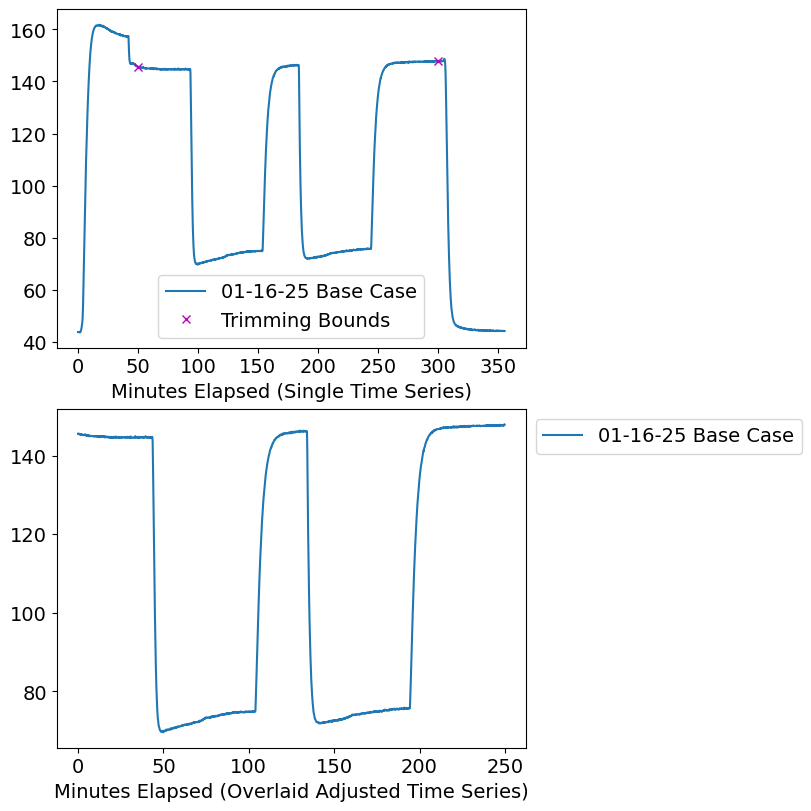

In [28]:
import process_cl2_logfile as process_cl2#This underline is unavoidable

path = (plot_default_properties['base_directory'] + '/01-06_Final Trials Campaigns/data/01-16_Cl_baseCase_noNaOH.csv')
exp_name = '01-16-25 Base Case'
ftir_path = plot_default_properties['base_directory'] + '/01-06_Final Trials Campaigns/data/01-16_ftir.prn'

info = (path,exp_name,ftir_path)

# Load the file... (path,exp_name,ftir_path)
hush=True
raw_data = process_cl2.extract_data([info[:2]], hush)

# Rebind the ftir
ftir_fields_to_rebind = (('CH4 (PF) 191c average','FTIR: CH4 (ppm)'),('CO2 ppm 191c average','FTIR: CO2 (ppm)'),
                         ('CO ppm 191C (1of2) average','FTIR: CO (ppm)'),('Formaldehyde 191c average','FTIR: CH2O (ppm)'),)

process_cl2.rebind_ftir_prn(raw_data[exp_name],ftir_path,ftir_fields_to_rebind,hush)

for df in raw_data.values():
    try:
        df['FTIR: CH2O (ppm)']+=0.5 #One can see on inspection that the 'baseline' CH2O value is -0.5, not 0, for some reason. We correct that.
        df['FTIR: CO2 (ppm)']-=1.5 #One can see on inspection that the 'baseline' CO2 value is 1.5, not 0, for some reason. We correct that.
    except: #FTIR widget not used, or said 'no reading' the whole time.
        pass

importlib.reload(process_cl2)
trim_params = [(50, 300)]
(data, ax1, ax2) = process_cl2.trim_dataframes(raw_data, trim_params, plot=True, which_field='Cl2 LabJack: Cl2 Node A (mV)', which_df=0)
rf = process_cl2.RemovalFinder(data, "01-16_cl2_misc_follow_ups")

importlib.reload(process_cl2)
#@np.vectorize
def subtract_cl2_zero(mv):# This zero stays fixed within a given campaign but may change from campaign to campaign due to tweaking the Cl2 sensor setup
    return (mv-44.1) #39.0)

def scale_cl2(mv):
    return (mv-44.1)*30/(145-44.1)

current_experiment = '01-16-25 Base Case'
rf.dump_experiment(current_experiment)
data[current_experiment]['Cl2 LabJack: Cl2 reading minus zero (mV)'] = scale_cl2(data[current_experiment]['Cl2 LabJack: Cl2 Node A (mV)'])

# Process the bypass periods
rf.set_tags('UV_distance_conv=50')
rf.isolate_bypass_periods(current_experiment)
# Process the CH4
rf.set_setup_values(which_field='FTIR: CH4 (ppm)')
rf.autofind_removal(current_experiment,start_time=0,end_time=1150,correct_drift=False)
#rf.plot_baseline_and_samples(current_experiment,which_field='Selected: CH4 (ppm)',color='C0',ax=ax2,marker='^',do_shading=True)
# Get the Cl2 data
rf.set_setup_values(which_field='Cl2 LabJack: Cl2 reading minus zero (mV)')
rf.autofind_removal(current_experiment,start_time=0,end_time=1150,correct_drift=False)


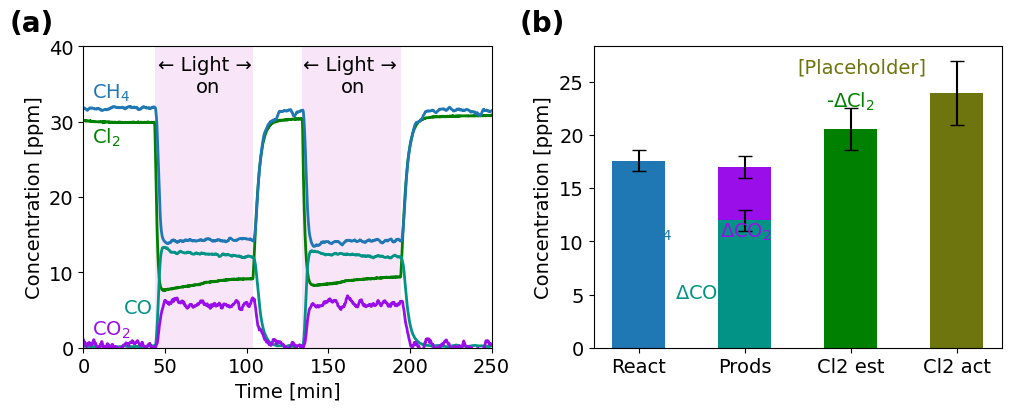

In [69]:
(fig,((ax_a,ax_b)))=plt.subplots(1,2,figsize=(plot_default_properties['figure_width'],4))

# a
ax_a.text(-0.18,1.05, "(a)", transform=ax_a.transAxes, size=plot_default_properties['subplot_letter_size'], weight='bold')

importlib.reload(process_cl2)
importlib.reload(cl2_utils)

# Add the UV light overlays
(on_times,off_times) = process_cl2.find_UV_changes(data[current_experiment]['UV Light: Actual Status'],data[current_experiment]['Minutes'])
for i in range(len(on_times)):
    ax_a.axvspan(on_times.iloc[i],off_times.iloc[i], color='m', alpha=0.1, lw=0)
ax_a.text(.305,0.97, '← Light → \non',ha='center',va='top',transform=ax_a.transAxes)
ax_a.text(0.66,0.97, '← Light → \non',ha='center',va='top',transform=ax_a.transAxes)
#ax_a.plot(data[current_experiment]['Minutes'],10*data[current_experiment]['UV Light: Actual Status'],color='xkcd:purple',label='UV Light: Status (AU)')

#rf.plot_baseline_and_samples(current_experiment,which_field='Cl2 LabJack: Cl2 reading minus zero (mV)',color='g',marker='o',ax=ax_a,do_shading=False)
cl2_utils.do_timeseries(ax_a,line_default_properties,'Cl2',data[current_experiment]['Minutes'],data[current_experiment]['Cl2 LabJack: Cl2 reading minus zero (mV)'])
cl2_utils.do_timeseries(ax_a,line_default_properties,'CH4',data[current_experiment]['Minutes'],data[current_experiment]['FTIR: CH4 (ppm)'])
cl2_utils.do_timeseries(ax_a,line_default_properties,'CO',data[current_experiment]['Minutes'],data[current_experiment]['FTIR: CO (ppm)'])
cl2_utils.do_timeseries(ax_a,line_default_properties,'CO2',data[current_experiment]['Minutes'],data[current_experiment]['FTIR: CO2 (ppm)'])
#cl2_utils.do_timeseries(ax_a,line_default_properties,'CH2O',data[current_experiment]['Minutes'],data[current_experiment]['FTIR: CH2O (ppm)'])

# Labeling
labels = (('Cl2',5,26.5,0),
          ('CH4',5,32.5,0),
          ('CO',25,4,0),
          ('CO2',5,1,0))
cl2_utils.label_tslines(ax_a,line_default_properties,labels)

#print(rf.translate_tags("UV_distance_conv=50; dummy='whatever'")['UV_distance_conv'])
ax_a.set_xlim(0,250)
ax_a.set_ylim(0,40)
ax_a.set_ylabel('Concentration [ppm]')
ax_a.set_xlabel('Time [min]')

#ax_a.plot([0],[0],'r*')

# b
ax_b.text(-0.18,1.05, "(b)", transform=ax_b.transAxes, size=plot_default_properties['subplot_letter_size'], weight='bold')
# Data for the bar chart
bar_labels = ['React', 'Prods', 'Cl2 est', 'Cl2 act']
(rad_count,rad_count_CI) = cl2_utils.get_cl_radical_budget(30)
bar_values = [[17.6], [12, 5], [20.6], [rad_count/2]]

# Add error bars
bar_errors = [[1], [1, 1], [2], [rad_count_CI/2]]

# Labeling
labels = (('CH4',.05,.35,0),
          ('CO',.2,.15,0),
          ('CO2',.31,.35,0),
          ('Cl2',.57,.78,0),
          ('Cl* Efficiency',.5,.9,0))

# Add error bars for the stacked bar chart
j = 0
for i, (label, values, errors) in enumerate(zip(bar_labels, bar_values, bar_errors)):
    bottom = 0
    for value, error in zip(values, errors):
        ax_b.bar(label, value, bottom=bottom, width=.5,color=line_default_properties[labels[j][0]]['color'])
        ax_b.errorbar(label, value + bottom, yerr=error, fmt='none', ecolor='black', capsize=5)
        bottom += value
        j += 1

# # Create bar chart
# j = 0
# for i, values in enumerate(bar_values):
#     bottom = 0
#     for value in values:
#         ax_b.bar(bar_labels[i], value, bottom=bottom, width=.5,color=line_default_properties[labels[j][0]]['color'])
#         bottom += value
#         j += 1

cl2_utils.label_lines(ax_b,line_default_properties,labels,True)

ax_b.set_ylabel('Concentration [ppm]')

plt.savefig('exported_images/base_case_results.png', bbox_inches='tight',dpi=300)
plt.show()

In [ ]:
# Load all the experimental data from the intermediate files. See the readme for where these files came from.
bypass_data_929 = pd.read_csv("../_exported_data/bypasses_09-29_cl2_campaign_after_mfc_zero.csv")
conversion_data_929 = pd.read_csv("../_exported_data/conversions_09-29_cl2_campaign_after_mfc_zero.csv")
bypass_data_924 = pd.read_csv("../_exported_data/bypasses_09-24_cl2_sweeps_no_cofeed.csv")
conversion_data_924 = pd.read_csv("../_exported_data/conversions_09-24_cl2_sweeps_no_cofeed.csv")
all_bypass_data = pd.concat([bypass_data_924,bypass_data_929],axis=0,ignore_index=True).reindex()
all_conversion_data = pd.concat([conversion_data_924,conversion_data_929],axis=0,ignore_index=True).reindex()

# Select data from only the the experiments we want
exps = ["01-16_Cl_baseCase_noNaOH.csv"]
bypass_data = all_bypass_data[all_bypass_data["experiment_name"].isin(exps)]
conversion_data = all_conversion_data[all_conversion_data["experiment_name"].isin(exps)]
conversion_data = conversion_data[(conversion_data['experiment_name']=="09-19-24 Vary Cl2 (5-30 ppm) at Fixed CH4") | # Use exp. with 100 ppm Cl2 tank for Cl2 5-30 ppm and exp. with 1000 ppm Cl2 tank for 45-90 ppm.
                                  (conversion_data['Cl2 LabJack: Cl2 reading minus zero (mV) baseline']>40)] # Proxy for >=45 ppm is a Cl2 measurement of more than 85mV
conversion_data=conversion_data.sort_values(by='Cl2 LabJack: Cl2 reading minus zero (mV) baseline',ascending=True)

# Extract the values and 95% CI from the CH4 conversion data
((ch4_conversions,ch4_95_ci),) = cl2_utils.extract_spectrometer_data_from_conversions(conversion_data,
            fields=['Selected: CH4 (ppm)'], percent_accuracy_95 = cl2_experiment_constants.picarro_percent_accuracy_95, absolute_accuracy_95 = cl2_experiment_constants.picarro_absolute_accuracy_95)

# Extract the values and 95% CI from the Cl2 conversion data
cl2_tank_ppms = 1000#np.array([1000 if b>40 else 100 for b in conversion_data['Cl2 LabJack: Cl2 reading minus zero (mV) baseline']]) # Only Cl2 conc's 45 and over used the 1000 ppm tank
(cl2_baseline, cl2_conversions, cl2_conversion_95_ci) = cl2_utils.extract_cl2_data_from_conversions(conversion_data,bypass_data,cl2_tank_ppms,cl2_experiment_constants.cl2_mfc_sccm_accuracy_95,cl2_experiment_constants.cl2_node_absolute_accuracy_95)
inlet_cl2 = cl2_baseline

# Extract the means and 95% CI's for each gas in each bypass period
fields = ['FTIR: CO2 (ppm)','FTIR: CO (ppm)','FTIR: CH2O (ppm)']
((co2,co2_95_ci),(co,co_95_ci),(ch2o,ch2o_95_ci)) = cl2_utils.extract_spectrometer_data_from_bypass(conversion_data,bypass_data,fields,percent_accuracy_95=5,absolute_accuracy_95=1)
